In [1]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data


In [2]:
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
# 数据集 两个样本 
sentences = [
        # enc_input           dec_input         dec_output label
        ['ich mochte ein bier P', 'S i want a beer .', 'i want a beer . E'],
        ['ich mochte ein cola P', 'S i want a coke .', 'i want a coke . E']
]


In [3]:
# Padding Should be Zero
src_vocab = {'P' : 0, 'ich' : 1, 'mochte' : 2, 'ein' : 3, 'bier' : 4, 'cola' : 5} # 德语数据集
src_vocab_size = len(src_vocab)

tgt_vocab = {'P' : 0, 'i' : 1, 'want' : 2, 'a' : 3, 'beer' : 4, 'coke' : 5, 'S' : 6, 'E' : 7, '.' : 8} # 英语数据集
idx2word = {i: w for i, w in enumerate(tgt_vocab)}
tgt_vocab_size = len(tgt_vocab)

src_len = 5 # enc_input max sequence length
tgt_len = 6 # dec_input(=dec_output) max sequence length
tgt_vocab_size

9

In [4]:
# Transformer Parameters
d_model = 512 # embedding size
d_ff = 2048   # Feedforward dimension
d_k = d_v = 64 # dimension of K(=Q) V
n_layers = 6
n_heads = 8

In [5]:
# 单词转换成索引
def make_data(sentences):
    enc_inputs , dec_inputs, dec_outputs = [],[],[]
    for i in range(len(sentences)):
        enc_input = [[src_vocab[n] for n in sentences[i][0].split()]] 
        dec_input = [[tgt_vocab[n] for n in sentences[i][1].split()]]
        dec_output = [[tgt_vocab[n] for n in sentences[i][2].split()]]
        
        enc_inputs.extend(enc_input)
        dec_inputs.extend(dec_input)
        dec_outputs.extend(dec_output)
    return torch.LongTensor(enc_inputs), torch.LongTensor(dec_inputs), torch.LongTensor(dec_outputs)

enc_inputs, dec_inputs, dec_outputs = make_data(sentences)

In [6]:
class MyDataSet(Data.Dataset):
    def __init__(self, enc_inputs, dec_inputs, dec_outputs):
        super(MyDataSet, self).__init__()
        self.enc_inputs = enc_inputs
        self.dec_inputs = dec_inputs
        self.dec_outputs = dec_outputs
        
    def __len__(self):
        return self.enc_inputs.shape[0]
    
    def __getitem__(self, idx):
        return self.enc_inputs[idx], self.dec_inputs[idx], self.dec_outputs[idx]
    
"""
torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0,
collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, multiprocessing_context=None,
generator=None, *, prefetch_factor=2, persistent_workers=False)
"""
loader = Data.DataLoader(MyDataSet(enc_inputs, dec_inputs, dec_outputs), 2, True)

In [7]:
a = torch.LongTensor([[1,2,3,4,0],[1,2,3,5,0]]) #[2,5]
a = a.data.eq(0).unsqueeze(1).expand([2,5,5]) # 2代表batch_size 5代表seq_len
print(a)
a = a.unsqueeze(1).repeat(1, 8 ,1, 1) #8代表n_heads
# a

tensor([[[False, False, False, False,  True],
         [False, False, False, False,  True],
         [False, False, False, False,  True],
         [False, False, False, False,  True],
         [False, False, False, False,  True]],

        [[False, False, False, False,  True],
         [False, False, False, False,  True],
         [False, False, False, False,  True],
         [False, False, False, False,  True],
         [False, False, False, False,  True]]])


In [8]:
a = torch.from_numpy(np.array([False, True, True]))
b = torch.from_numpy(np.array([1, 0, 2]))
print(a+b)

tensor([1, 1, 3])


In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float()*(-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position*div_term)
        pe[:, 1::2] = torch.cos(position*div_term)
        pe = pe.unsqueeze(0).transpose(0,1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x:[seq_len, batch_size, d_model]
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [10]:
# feedforward layer
# class PoswiseFeedForwardNet(nn.Module):
#     def __init__(self):
#         super(PoswiseFeedForwardNet, self).__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(d_model, d_ff, bias=False),
#             nn.ReLU(),
#             nn.Linear(d_ff, d_model, bias=False)
#         )
        
#     def forward(self,inputs):
#         # inputs:[batch_size, seq_len, d_model]
#         residual = inputs
#         output = self.fc(inputs)
#         return nn.LayerNorm(d_model).cuda()(output+residual) #[batch_size, seq_len, d_model]
    
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=False),
            nn.ReLU(),
            nn.Linear(d_ff, d_model, bias=False)
        )
    def forward(self, inputs):
        '''
        inputs: [batch_size, seq_len, d_model]
        '''
        residual = inputs
        output = self.fc(inputs)
        return nn.LayerNorm(d_model).cuda()(output + residual) # [batch_size, seq_len, d_model]

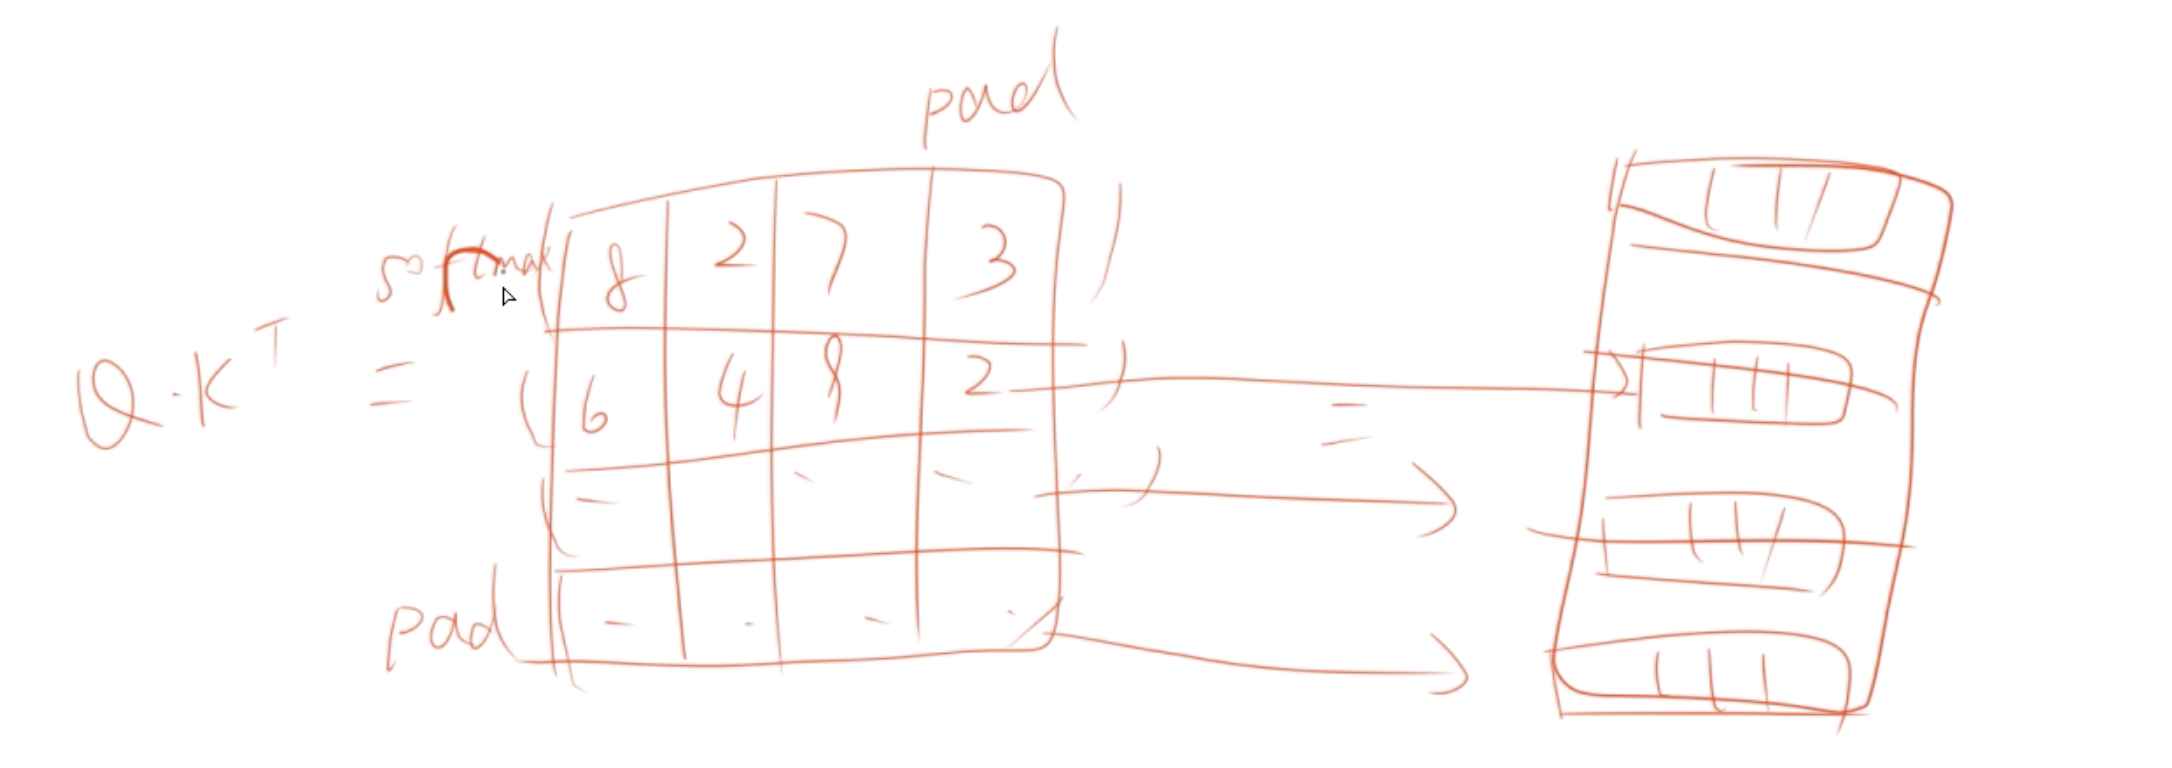

In [11]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()
        
    def forward(self, Q, K, V, attn_mask):
        """
        Q:[batch_size, n_heads, len_q, d_k]
        K:[batch_size, n_heads, len_k, d_k]
        V:[batch_sizem,n_heads, len_v(=len_k), d_v]
        attn_mask:[batch_size, n_heads, seq_len, seq_len]
        """
        scores = torch.matmul(Q, K.transpose(-1,-2)) / np.sqrt(d_k) # scores:[batch_size, n_heads, len_q, len_k]
        scores.masked_fill_(attn_mask, -1e9) # 填充True的地方为负无穷
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn,V) #[batch_size, n_heads, len_q, d_v]
        return context, attn
        
    
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k*n_heads, bias=False)
        self.W_K = nn.Linear(d_model, d_k*n_heads, bias=False)
        self.W_v = nn.Linear(d_model, d_v*n_heads, bias=False)
        self.fc = nn.Linear(n_heads*d_v, d_model, bias=False)
        
    def forward(self, input_Q, input_K, input_V, attn_mask):
        """
        input_Q:[batch_size, len_q, d_model]
        input_K:[batch_size, len_k, d_model]
        input_V:[batch_size, len_v(=len_k), d_model]
        attn_mask:[batch_size, seq_len, seq_len]
        """
        residual, batch_size = input_Q, input_Q.size(0)
        # (B,S,D) -proj-> (B,S,D_NEW) -split-> (B,S,H,W) -trans-> (B,H,S,W)
        Q = self.W_Q(input_Q).view(batch_size, -1 , n_heads, d_k).transpose(1,2) # Q:[batch_size, n_heads, len_q, d_k]
        K = self.W_Q(input_K).view(batch_size, -1 , n_heads, d_k).transpose(1,2) # Q:[batch_size, n_heads, len_k, d_k]
        V = self.W_Q(input_V).view(batch_size, -1 , n_heads, d_k).transpose(1,2) # Q:[batch_size, n_heads, len_v(=len_k), d_k]
        
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask:[batch_size, n_heads, seq_len, seq_len]
        
        # context:[batch_size, n_heads, len_q, d_v]
        # attn:[batch_size, n_heads, len_q, len_k]
        context, attn = ScaledDotProductAttention()(Q, K ,V, attn_mask)
        context = context.transpose(1,2).reshape(batch_size, -1, n_heads*d_v) # context:[batch_size, len_q, n_heads*d_v]
        output = self.fc(context)
        return nn.LayerNorm(d_model)(output+residual), attn
        

In [12]:
# 拼接上面的组件
# class EncoderLayer(nn.Module):
#     def __init__(self):
#         super(EncoderLayer, self).__init__()
#         self.enc_self_attn = MultiHeadAttention()
#         self.pos_ffn = PoswiseFeedForwardNet()
        
#     def forward(self, enc_inputs, enc_self_attn_mask):
#         """
#         enc_inputs:[batch_size, src_len, d_model]
#         enc_self_attn_mask:[batch_size, src_len, src_len]
#         """
#         # enc_outputs:[batch_size, src_len, d_model]
#         # attn:[batch_size, n_heads, src_len, src_len]
#         enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same QKV
#         enc_outputs = self.pos_ffn(enc_inputs) # enc_outputs:[batch_size, src_len, d_model]
#         return enc_outputs, attn
    
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        '''
        enc_inputs: [batch_size, src_len, d_model]
        enc_self_attn_mask: [batch_size, src_len, src_len]
        '''
        # enc_outputs: [batch_size, src_len, d_model], attn: [batch_size, n_heads, src_len, src_len]
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size, src_len, d_model]
        return enc_outputs, attn

In [13]:
def get_sinusoid_encoding_table(n_position, d_model):
    def cal_angle(position, hid_idx):
        return position/np.power(10000, 2*(hid_idx//2)/d_model)
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return torch.FloatTensor(sinusoid_table)

def get_attn_pad_mask(seq_q, seq_k):
    """
    seq_q:[batch_size,seq_len]
    seq_k:[batch_size,seq_len]
    seq_len 是src_len或tgt_len  可能是不同的长度
    """
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1) # [batch_size, 1, len_k] False is masked 扩维，因为word_emb是三维的
    return pad_attn_mask.expand(batch_size, len_q, len_k) # [batch_size, len_q, len_k]
    

    

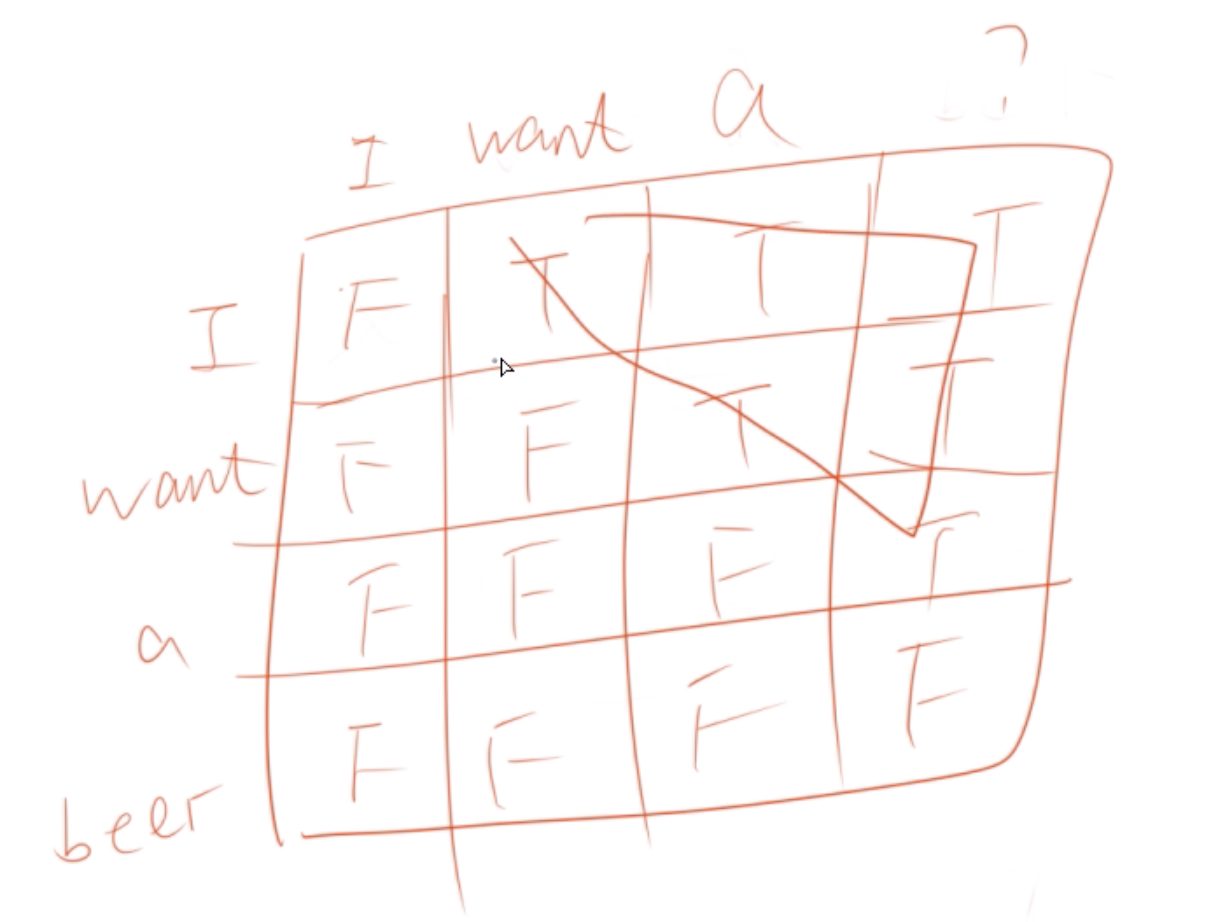
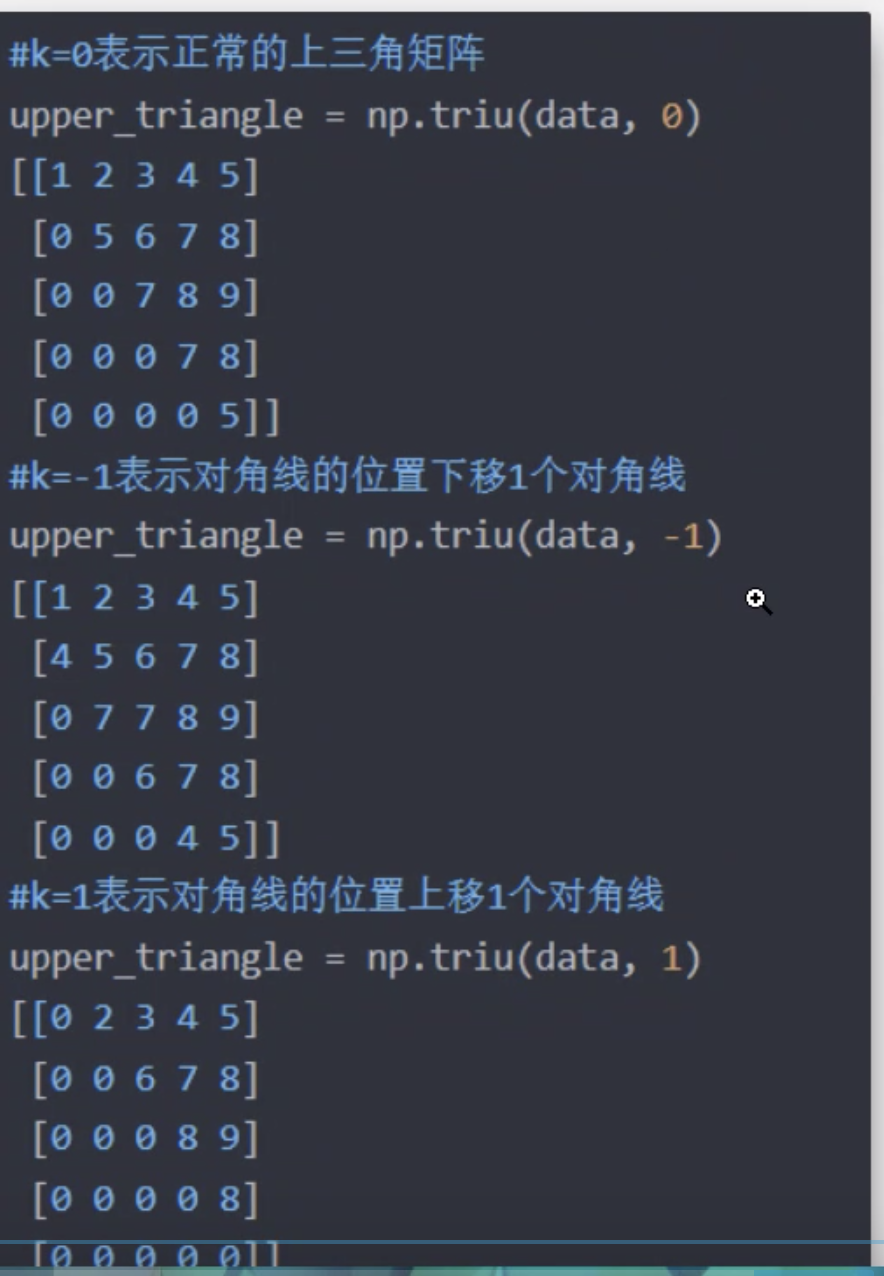

In [14]:
def get_attn_subsequence_mask(seq):
    """
    seq:[batch_size, tgt_len]
    """
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1) # Upper triangular matrix
    subsequence_mask = torch.from_numpy(subsequence_mask).byte() #byte 非零即1
    return subsequence_mask # [batch_size, tgt_len, tgt_len]

In [15]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model) #(9,512)
#         self.pos_emb = nn.PositionalEncoding(d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(src_vocab_size, d_model), freeze=True)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])
        
    def forward(self, enc_inputs):
        # enc_inputs:[batch_size, src_len]
        word_emb = self.src_emb(enc_inputs) # [batch_size, src_len, d_model]
        pos_emb = self.pos_emb(enc_inputs) #[batch_size, src_len, d_model]
        enc_outputs = word_emb+pos_emb
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs) # [batch_size, src_len, src_len]
        enc_self_attns = [] # 为画图用 可以用热力图
        for layer in self.layers:
            # enc_outputs:[batch_size, src_len ,d_model] 
            # enc_self_attn:[batch_size, n_heads, src_len, src_len]
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

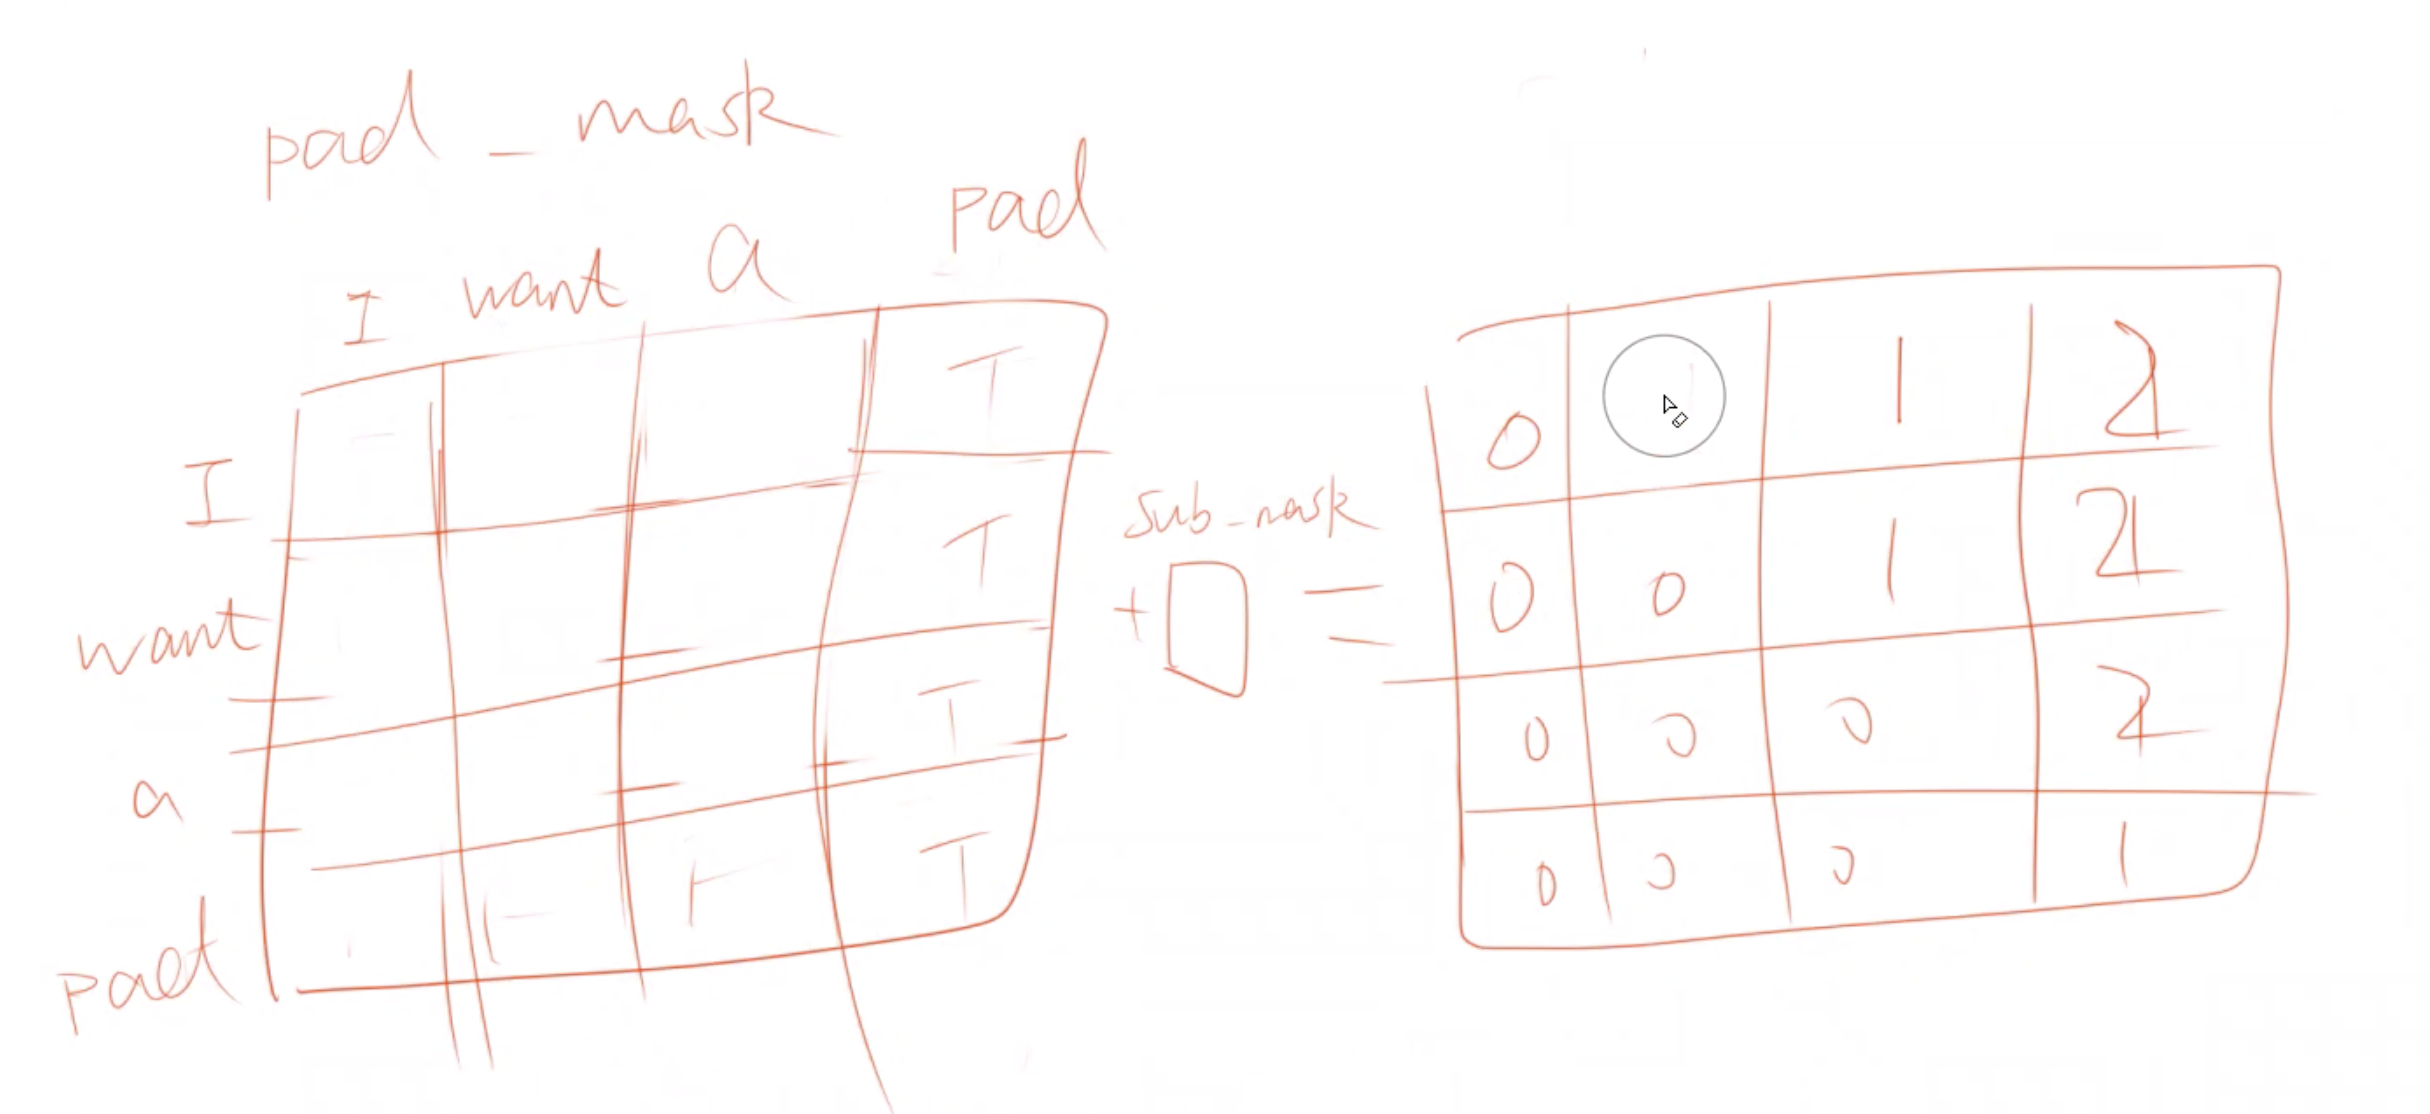

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.doc_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()
        
    def forward(self, dec_inputs, enc_inputs, dec_self_attn_mask, dec_enc_attn_mask):
        """
        dec_inputs :[batch_size, tgt_len, d_model]
        enc_outputs:[batch_size, src_len, d_model]
        dec_self_attn_mask:[batch_size, tgt_len, tgt_len]
        dec_enc_attn_mask:[batch_size, tgt_len, src_len]
        """
        # dec_outputs:[batch_size, tgt_len, d_model]
        # dec_self_attn:[batch_size, n_heads, tgt_len, tgt_len]
        dec_outputs, dec_enc_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        
        # dec_outputs:[batch_size, tgt_len, d_model]
        # dec_enc_attn:[batch_size, n_heads, tgt_len, src_len]
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs) #[batch_size, tgt_len, d_model]
        return dec_outputs, dec_self_attn, dec_enc_attn

In [17]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(tgt_vocab_size, d_model), freeze=True)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])
        
        
    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        """
        dec_inputs:[batch_size, tgt_len]
        enc_inputs:[batch_size, src_len]
        enc_outputs:[batch_size, src_len, d_model]
        """
        word_emb = self.tgt_emb(dec_inputs) #[batch_size, tgt_len, d_model]
        dec_outputs = word_emb+pos_emb
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)  # [batch_size, tgt_len, tgt_len]
        dec_self_attn_subsequence_mask = get_attn_subsequence_mask(dec_inputs)  # 当前时刻是不能看见未来信息的 
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask, dec_self_attn_subsequence_mask), 0) # [batch_size, tgt_len, tgt_len]  gt判断这个矩阵里的数 和0比，大于True 反之 False
        
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs) #[batch_size, tgt_len , src_len]
        
        dec_self_attns, dec_enc_attns = [],[]
        for layer in self.layers:
            # dec_outputs:[batch_size, tgt_len, d_model]
            # dec_self_attn:[batch_size, n_heads, tgt_len, tgt_len]
            # dec_enc_attn:[batch_size, n_heads, tgt_len, src_len]
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns
        

In [18]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder().cuda()
        self.decoder = Decoder().cuda()
        self.projection = nn.Linear(d_model,tgt_vocab_size, bias=False).cuda()
        
    def forward(self, enc_inputs, dec_inputs):
        """
        enc_inputs :[batch_size, src_len]
        dec_inputs :[batch_size, tgt_len]
        """
        # enc_outputs:[batch_size, src_len, d_model]
        # enc_sel_attns:[n_layers, batch_size, n_heads, tgt_len, tgt_len]
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        # enc_outputs:[batch_size, src_len, d_model]
        # enc_self_attns:[n_layers, batch_size, n_heads, tgt_len, tgt_len]
        # dec_enc_attn:[n_layers, batch_size, tgt_len, src_len]
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs) # dec_logits:[batch_size, tgt_len, tgt_vocab_size]
        # -1把batch_size 和tgt_len拼起来
        return dec_logits.view(-1, dec_logits.size(-1)) , enc_self_attns, dec_self_attns, dec_enc_attns

In [19]:
model = Transformer()
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)

In [20]:
for epoch in range(30):
    for enc_inputs, dec_inputs, dec_outputs in loader:
        '''
        enc_inputs: [batch_size, src_len]
        dec_inputs: [batch_size, tgt_len]
        dec_outputs: [batch_size, tgt_len]
        '''
        enc_inputs, dec_inputs, dec_outputs = enc_inputs.cuda(), dec_inputs.cuda(), dec_outputs.cuda()
        # outputs: [batch_size * tgt_len, tgt_vocab_size]
        outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
        loss = criterion(outputs, dec_outputs.view(-1))
        print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

RuntimeError: CUDA error: an illegal memory access was encountered